In [1]:
from loguru import logger
import pomegranate as pg
import pymc3 as pm
# import pystan
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
# import plotly.express as px
import string
import random
from time import time
# import arviz as az
import theano.tensor as tt
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow_probability import distributions as tfd
# from tensorflow_probability import bijectors as tfb

In [4]:
real_df=pd.read_csv('../datasets/rs_bq_joined_table_user_path_orders.csv')
print('Real_df shape: ',real_df.shape)
df_s=real_df.sort_values(by='client_id').head(50000)
del real_df
print('Real_df shape: ',df_s.shape)
df_s.head()

Real_df shape:  (195549, 3)
Real_df shape:  (50000, 3)


,client_id,agg_sessions,num_orders
141538,000021cafb59adc815e9841433d26acf,cpc:0:0:-1,1
184374,00007b917e276f8d17daef8225debb5b,"cpc,cpc:0,0:0,0:-1",2
80217,00008b3e105c302a3c65cc95f93c82b5,"cpc,organic:2,1:0,0:-1",3
154142,0000a6ee933edfc9cc33407d5998a5b7,cpc:1:0:-1,1
166165,0000fa4dfe368f0d024a04d83fa13cc0,(none):0:0:-1,3


In [5]:
df_s['agg_sessions']=df_s['agg_sessions'].str.split(';')#.explode().str.split(':')
df_s=df_s.explode('agg_sessions')
df_s['agg_sessions']=df_s['agg_sessions'].str.split(':')
df_s

,client_id,agg_sessions,num_orders
141538,000021cafb59adc815e9841433d26acf,"[cpc, 0, 0, -1]",1
184374,00007b917e276f8d17daef8225debb5b,"[cpc,cpc, 0,0, 0,0, -1]",2
80217,00008b3e105c302a3c65cc95f93c82b5,"[cpc,organic, 2,1, 0,0, -1]",3
154142,0000a6ee933edfc9cc33407d5998a5b7,"[cpc, 1, 0, -1]",1
166165,0000fa4dfe368f0d024a04d83fa13cc0,"[(none), 0, 0, -1]",3
...,...,...,...
21045,414886f6a62f65a45d5f94de850397c9,"[organic,(not set),organic,cpc, 0,0,0,1, 0,0,0...",1
21045,414886f6a62f65a45d5f94de850397c9,"[cpc,cpc, 1,1, 1,1, 44.98]",1
21045,414886f6a62f65a45d5f94de850397c9,"[cpc, 1, 0, -1]",1
110863,4148c8543f6ecfa0ab3d5d6ea32d59ae,"[(none), 29, 0, -1]",12


In [6]:
df_s['media']=df_s['agg_sessions'].apply(lambda x: x[0])
df_s['nviews']=df_s['agg_sessions'].apply(lambda x: x[1])
df_s['to_cart']=df_s['agg_sessions'].apply(lambda x: x[2])
df_s['value']=df_s['agg_sessions'].apply(lambda x: np.asarray(x[3]))
df_s=df_s.reset_index().reset_index().rename(columns={'level_0':'sess_idx','index':'client_index'})
df_s

,sess_idx,client_index,client_id,agg_sessions,num_orders,media,nviews,to_cart,value
0,0,141538,000021cafb59adc815e9841433d26acf,"[cpc, 0, 0, -1]",1,cpc,0,0,-1
1,1,184374,00007b917e276f8d17daef8225debb5b,"[cpc,cpc, 0,0, 0,0, -1]",2,"cpc,cpc","0,0","0,0",-1
2,2,80217,00008b3e105c302a3c65cc95f93c82b5,"[cpc,organic, 2,1, 0,0, -1]",3,"cpc,organic","2,1","0,0",-1
3,3,154142,0000a6ee933edfc9cc33407d5998a5b7,"[cpc, 1, 0, -1]",1,cpc,1,0,-1
4,4,166165,0000fa4dfe368f0d024a04d83fa13cc0,"[(none), 0, 0, -1]",3,(none),0,0,-1
...,...,...,...,...,...,...,...,...,...
61643,61643,21045,414886f6a62f65a45d5f94de850397c9,"[organic,(not set),organic,cpc, 0,0,0,1, 0,0,0...",1,"organic,(not set),organic,cpc","0,0,0,1","0,0,0,0",-1
61644,61644,21045,414886f6a62f65a45d5f94de850397c9,"[cpc,cpc, 1,1, 1,1, 44.98]",1,"cpc,cpc","1,1","1,1",44.98
61645,61645,21045,414886f6a62f65a45d5f94de850397c9,"[cpc, 1, 0, -1]",1,cpc,1,0,-1
61646,61646,110863,4148c8543f6ecfa0ab3d5d6ea32d59ae,"[(none), 29, 0, -1]",12,(none),29,0,-1


In [5]:
# serie_to_vals=df_s['agg_sessions'].str.split(';').explode().str.split(':')
# serie_to_vals

In [6]:
# df_aux=pd.DataFrame()
# df_aux['media']=serie_to_vals.apply(lambda x: x[0]).rename('media')
# df_aux['nviews']=serie_to_vals.apply(lambda x: x[1]).rename('nviews')
# df_aux['to_cart']=serie_to_vals.apply(lambda x: x[2]).rename('to_cart')
# df_aux['value']=serie_to_vals.apply(lambda x: np.asarray(x[3],dtype=float)).rename('value')
# # df_aux['media']=serie_to_vals.apply(lambda x: x[0]).rename('media')
# # df_aux['nviews']=serie_to_vals.apply(lambda x: np.fromstring(x[1],dtype=int,sep=',')).rename('nviews')
# # df_aux['to_cart']=serie_to_vals.apply(lambda x: np.fromstring(x[2],dtype=int,sep=',')).rename('to_cart')
# # df_aux['value']=serie_to_vals.apply(lambda x: np.asarray(x[3],dtype=float)).rename('value')
# df_aux

In [7]:
# df_s=df_s.join(df_aux).reset_index().reset_index().rename(columns={'level_0':'sess_idx','index':'client_index'})
# del df_aux
# df_s

In [7]:
nviews=df_s['nviews'].apply(lambda x: np.fromstring(x,dtype=int,sep=','))
print('Input to HMM:\n',nviews)
# nviews=df_s.groupby('client_id')['nviews'].apply(lambda x: x).apply(lambda x: np.fromstring(x,dtype=int,sep=','))
# print(nviews.loc[133])

Input to HMM:
 0                 [0]
1              [0, 0]
2              [2, 1]
3                 [1]
4                 [0]
             ...     
61643    [0, 0, 0, 1]
61644          [1, 1]
61645             [1]
61646            [29]
61647             [0]
Name: nviews, Length: 61648, dtype: object


In [8]:
#checking one specific consumer
id_to_analyse=df_s['client_id'].value_counts().index[0]
df_s[df_s['client_id']==id_to_analyse]

,sess_idx,client_index,client_id,agg_sessions,num_orders,media,nviews,to_cart,value
48905,48905,113691,33b33fedff600e6d946c455f88d25375,"[cpc,re, 1,4, 0,0, -1]",45,"cpc,re","1,4","0,0",-1
48906,48906,113691,33b33fedff600e6d946c455f88d25375,"[re, 8, 1, 79.99]",45,re,8,1,79.99
48907,48907,113691,33b33fedff600e6d946c455f88d25375,"[re,re,re,re, 1,1,1,1, 0,0,0,0, -1]",45,"re,re,re,re","1,1,1,1","0,0,0,0",-1
48908,48908,113691,33b33fedff600e6d946c455f88d25375,"[re, 0, 1, 94.99]",45,re,0,1,94.99
48909,48909,113691,33b33fedff600e6d946c455f88d25375,"[re,re,re,re,re,re, 1,1,1,1,2,1, 0,0,0,0,0,0, -1]",45,"re,re,re,re,re,re","1,1,1,1,2,1","0,0,0,0,0,0",-1
48910,48910,113691,33b33fedff600e6d946c455f88d25375,"[re, 4, 1, 108.2]",45,re,4,1,108.2
48911,48911,113691,33b33fedff600e6d946c455f88d25375,"[cpc,re,re,re,re,re,re,cpc,cpc,cpc, 2,1,1,1,1,...",45,"cpc,re,re,re,re,re,re,cpc,cpc,cpc","2,1,1,1,1,1,1,0,0,2","0,0,0,0,0,0,0,0,0,0",-1
48912,48912,113691,33b33fedff600e6d946c455f88d25375,"[re, 2, 1, 279.89]",45,re,2,1,279.89
48913,48913,113691,33b33fedff600e6d946c455f88d25375,"[re, 1, 1, 299.9]",45,re,1,1,299.9
48914,48914,113691,33b33fedff600e6d946c455f88d25375,"[cpc,re, 0,1, 0,0, -1]",45,"cpc,re","0,1","0,0",-1


In [9]:
df_aux=pd.DataFrame()
df_aux['exp_media']=df_s['media'].str.split(',').explode()
df_aux['exp_nviews']=df_s['nviews'].str.split(',').explode().apply(lambda x: np.array(x,dtype=int))
df_aux['exp_to_cart']=df_s['to_cart'].str.split(',').explode().apply(lambda x: np.array(x,dtype=int))
# df_aux
df_sexp=df_s.drop(columns=['agg_sessions','media','nviews','to_cart']).join(df_aux)
del df_aux
df_sexp

,sess_idx,client_index,client_id,num_orders,value,exp_media,exp_nviews,exp_to_cart
0,0,141538,000021cafb59adc815e9841433d26acf,1,-1,cpc,0,0
1,1,184374,00007b917e276f8d17daef8225debb5b,2,-1,cpc,0,0
1,1,184374,00007b917e276f8d17daef8225debb5b,2,-1,cpc,0,0
2,2,80217,00008b3e105c302a3c65cc95f93c82b5,3,-1,cpc,2,0
2,2,80217,00008b3e105c302a3c65cc95f93c82b5,3,-1,organic,1,0
...,...,...,...,...,...,...,...,...
61644,61644,21045,414886f6a62f65a45d5f94de850397c9,1,44.98,cpc,1,1
61644,61644,21045,414886f6a62f65a45d5f94de850397c9,1,44.98,cpc,1,1
61645,61645,21045,414886f6a62f65a45d5f94de850397c9,1,-1,cpc,1,0
61646,61646,110863,4148c8543f6ecfa0ab3d5d6ea32d59ae,12,-1,(none),29,0


In [10]:
df_sexp[df_sexp['client_id']==id_to_analyse]

,sess_idx,client_index,client_id,num_orders,value,exp_media,exp_nviews,exp_to_cart
48905,48905,113691,33b33fedff600e6d946c455f88d25375,45,-1,cpc,1,0
48905,48905,113691,33b33fedff600e6d946c455f88d25375,45,-1,re,4,0
48906,48906,113691,33b33fedff600e6d946c455f88d25375,45,79.99,re,8,1
48907,48907,113691,33b33fedff600e6d946c455f88d25375,45,-1,re,1,0
48907,48907,113691,33b33fedff600e6d946c455f88d25375,45,-1,re,1,0
48907,48907,113691,33b33fedff600e6d946c455f88d25375,45,-1,re,1,0
48907,48907,113691,33b33fedff600e6d946c455f88d25375,45,-1,re,1,0
48908,48908,113691,33b33fedff600e6d946c455f88d25375,45,94.99,re,0,1
48909,48909,113691,33b33fedff600e6d946c455f88d25375,45,-1,re,1,0
48909,48909,113691,33b33fedff600e6d946c455f88d25375,45,-1,re,1,0


In [11]:
df_sexp[df_sexp['client_id']==id_to_analyse].groupby('client_index')['sess_idx'].apply(list)

client_index
113691    [48905, 48905, 48906, 48907, 48907, 48907, 489...
Name: sess_idx, dtype: object

# 0. Generic DF

In [4]:
# df=pd.DataFrame(columns=['hash_id','state','medium_from','session','nviews','is_conversion'])
# n_samples=10000
# n_clients=2000

# #creating states
# states=['disingaged','engaged','active','conversion']
# s_prob=[0.5,0.3,0.1,0.1]
# df['state']=np.random.choice(states,n_samples, p=s_prob)
# #create is_conversion
# df['is_conversion']=0
# df['is_conversion'].loc[df['state']=='conversion']=1
# #creating medium
# media = ['re', '(none)', 'cpc','Null','email','organic','fb']
# m_prob=[0.1, 0.15, 0.2,0.3,0.1,0.1,0.05]
# df['medium_from']=np.random.choice(media, n_samples, p=m_prob)

# # #creating n_views by medium
# # eta_s_true=[3,10, 20, 30, 40, 50 ,60]
# # for s, N,eta_true in zip(df['medium_from'].value_counts().index,df['medium_from'].value_counts().values,eta_s_true):
# #   df['nviews'].loc[(df['medium_from']==s)]=stats.poisson.rvs(eta_true, size=(N,))

# #creating n_views by state
# eta_s_true=[3,20, 40, 60]
# for s, N,eta_true in zip(df['state'].value_counts().index,df['state'].value_counts().values,eta_s_true):
#   df['nviews'].loc[(df['state']==s)]=stats.poisson.rvs(eta_true, size=(N,))

# # creating fake hash_id
# clients=[]
# for _ in range(n_clients):
#   lst = [random.choice(string.ascii_letters + string.digits) for n in range(32)]
#   clients.append("".join(lst))
# df['hash_id']=np.random.choice(clients,n_samples,1/len(clients))
# # #creating clients group
# cg_prob=[0.6, 0.4]
# cg_elem=['g1','g2']
# df['c_g']=np.random.choice(cg_elem,n_samples,p=cg_prob)
# df['c_g_fac'],map_cg_fac=df['c_g'].factorize(sort=True)
# # #creating DMA groups 1 / BR region
# DMA_prob=[0.15,0.5, 0.05,0.25,0.05]
# DMA_elem=['sul','sudeste','centrooeste','nordeste','norte']
# df['dma']=np.random.choice(DMA_elem,n_samples,p=DMA_prob)
# df['dma_fac'],map_dma_fac=df['dma'].factorize(sort=True)
# #creating sessions
# df['session']=0
# df['session']=df.groupby(['hash_id']).cumcount()
# #creating index for state
# df['state_fac'],map_s_fac=df['state'].factorize(sort=True)
# df['medium_fac'],map_m_fac=df['medium_from'].factorize(sort=True)
# # df['cvg']=df.groupby(['hash_id','is_conversion']).cumcount()
# # groups = len(np.unique(y))

In [5]:
# df

,hash_id,state,medium_from,session,nviews,is_conversion,c_g,c_g_fac,dma,dma_fac,state_fac,medium_fac
0,c7O367a5YrObCCXXFYe7SL6HQKlQQ32F,conversion,(none),0,41,1,g1,0,sudeste,3,1,0
1,pQdyBQLQy5JNk0yPTWjHO1ZpkeUljdXi,disingaged,organic,0,3,0,g2,1,sul,4,2,5
2,AuOWDJKGkve2OmErgFoTErUUkg9RTf5C,disingaged,re,0,4,0,g2,1,nordeste,1,2,6
3,u0h9GWAAY68Tvdlq8IFwY2yosEaRkWhU,engaged,organic,0,19,0,g2,1,sudeste,3,3,5
4,Zv1EXhsHXACOLB2BTggRbxgHa3nMKKuF,active,Null,0,51,0,g1,0,sul,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,XkcCjO1q4z2pIg0ISp1vmWwWXmPJDKaz,engaged,re,5,19,0,g1,0,nordeste,1,3,6
9996,HZiIqDnAIafkyUyRzHVFvCUFzjoVQJUh,conversion,Null,7,51,1,g2,1,sudeste,3,1,1
9997,2vqZTkyhpEoHyugbHrRYEW7vbY3AxdQh,disingaged,re,7,3,0,g1,0,sudeste,3,2,6
9998,zGciO9siYAa7aDdWB4ZkPgltAb8mh66b,conversion,Null,1,44,1,g2,1,nordeste,1,1,1


In [292]:
# #(n_i,n_s,n_z,n_m,n_t)
# idx=df[['c_g_fac','state_fac','dma_fac','medium_fac','session']].values
# n_i=df['c_g_fac'].unique().shape[0] #types of clientes
# n_s=df['state_fac'].unique().shape[0] #hidden states
# n_z=df['dma_fac'].unique().shape[0] #DMA 
# n_m=df['medium_fac'].unique().shape[0] #number of medium
# n_t=df['session'].unique().shape[0] #number of the session of the medium exposure
# total_shape=(n_i,n_s,n_z,n_m,n_t)
# total_shape

In [294]:
# # df.groupby('hash_id')['nviews'].apply(list).values
# # df.groupby('hash_id')['is_conversion'].apply(list).values
# nviews=df.groupby('hash_id')['nviews'].apply(list).values
# viewlen=df.groupby('hash_id')['nviews'].apply(len).values

In [293]:
# df.groupby('hash_id')[['nviews','is_conversion']].agg(lambda x: x.to_list())

# HMM

In [12]:
def generating_pg_hmm_for_comparison(X):
    # model 1
    d1=pg.PoissonDistribution(4)
    s0=pg.State(d1,name='d')
    s1=pg.State(d1,name='a')
    s2=pg.State(d1,name='e')
    s3=pg.State(d1,name='c')
    hmm=pg.HiddenMarkovModel()
    hmm.add_transition(hmm.start, s0, 0.5)
    hmm.add_transition(hmm.start, s1, 0.3)
    hmm.add_transition(hmm.start, s2, 0.2)
    hmm.add_transition(hmm.start, s3, 0.0)
    hmm.add_transition(s3, hmm.end, 1.0)
    hmm.add_transition(s0, s0, 0.25)
    hmm.add_transition(s0, s1, 0.25)
    hmm.add_transition(s0, s2, 0.25)
    hmm.add_transition(s0, s3, 0.25)
    hmm.add_transition(s1, s1, 0.25)
    hmm.add_transition(s1, s2, 0.25)
    hmm.add_transition(s1, s3, 0.25)
    hmm.add_transition(s2, s2, 0.25)
    hmm.add_transition(s2, s3, 0.25)
    hmm.add_transition(s3, s3, 0.25)
    hmm.bake()
#fitting model 1
    _=hmm.fit(X,verbose=True)

#     model 2
    hmm_fs=pg.HiddenMarkovModel.from_samples(pg.PoissonDistribution, n_components=4, X=X,verbose=True)
    
    return hmm,hmm_fs

In [13]:
hmm_fit,hmm_fs=generating_pg_hmm_for_comparison(X=nviews)

[1] Improvement: nan	Time (s): 17.12
Total Training Improvement: nan
Total Training Time (s): 35.0541
[1] Improvement: 113027.09352317717	Time (s): 11.94
[2] Improvement: 695.8099530315376	Time (s): 12.26
[3] Improvement: 204.3954747391399	Time (s): 11.89
[4] Improvement: 74.26882074261084	Time (s): 12.05
[5] Improvement: 29.115046104590874	Time (s): 12.19
[6] Improvement: 11.842397702333983	Time (s): 12.66
[7] Improvement: 4.926390205160715	Time (s): 16.12
[8] Improvement: 2.085024542204337	Time (s): 19.05
[9] Improvement: 0.8984393794671632	Time (s): 18.84
[10] Improvement: 0.39712660128134303	Time (s): 22.17
[11] Improvement: 0.18327454495010898	Time (s): 23.8
[12] Improvement: 0.09112136988551356	Time (s): 24.06
[13] Improvement: 0.050869901810074225	Time (s): 16.53
[14] Improvement: 0.03290320679661818	Time (s): 15.18
[15] Improvement: 0.024574305425630882	Time (s): 12.04
[16] Improvement: 0.02045097149675712	Time (s): 12.83
[17] Improvement: 0.01818585896398872	Time (s): 14.36
[1

[147] Improvement: 1.7539423424750566e-05	Time (s): 14.45
[148] Improvement: 1.6687758034095168e-05	Time (s): 13.73
[149] Improvement: 1.577424700371921e-05	Time (s): 13.29
[150] Improvement: 1.4884892152622342e-05	Time (s): 13.76
[151] Improvement: 1.413322752341628e-05	Time (s): 14.63
[152] Improvement: 1.3345939805731177e-05	Time (s): 14.34
[153] Improvement: 1.2594304280355573e-05	Time (s): 13.93
[154] Improvement: 1.2017437256872654e-05	Time (s): 15.09
[155] Improvement: 1.1352181900292635e-05	Time (s): 14.21
[156] Improvement: 1.0712217772379518e-05	Time (s): 13.45
[157] Improvement: 1.0208284948021173e-05	Time (s): 13.24
[158] Improvement: 9.512121323496103e-06	Time (s): 14.12
[159] Improvement: 9.105162462219596e-06	Time (s): 14.02
[160] Improvement: 8.690956747159362e-06	Time (s): 13.3
[161] Improvement: 8.143222657963634e-06	Time (s): 13.32
[162] Improvement: 7.700175046920776e-06	Time (s): 13.62
[163] Improvement: 7.304275641217828e-06	Time (s): 13.42
[164] Improvement: 6.84

In [14]:
print('\nHMM model fitting type 1:\n')
print('start : \n',np.round(hmm_fit.dense_transition_matrix()[hmm_fit.start_index],3))
print('end : \n',np.round(hmm_fit.dense_transition_matrix()[hmm_fit.end_index],3))
print('Transition matrix: \n',np.round(hmm_fit.dense_transition_matrix(),3))


HMM model fitting type 1:

start : 
 [0.301 0.    0.476 0.223 0.    0.   ]
end : 
 [0. 0. 0. 0. 0. 0.]
Transition matrix: 
 [[0.327 0.379 0.    0.294 0.    0.   ]
 [0.    0.167 0.    0.    0.    0.833]
 [0.216 0.35  0.228 0.205 0.    0.   ]
 [0.    0.42  0.    0.58  0.    0.   ]
 [0.301 0.    0.476 0.223 0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]


In [15]:
print('\nHMM model from_sample type 2:\n')

print('start : \n',np.round(hmm_fs.dense_transition_matrix()[hmm_fs.start_index],3))
print('end : \n',np.round(hmm_fs.dense_transition_matrix()[hmm_fs.end_index],3))
print('Transition matrix: \n',np.round(hmm_fs.dense_transition_matrix(),3))


HMM model from_sample type 2:

start : 
 [0.736 0.065 0.184 0.015 0.    0.   ]
end : 
 [0. 0. 0. 0. 0. 0.]
Transition matrix: 
 [[0.909 0.015 0.075 0.001 0.    0.   ]
 [0.378 0.195 0.36  0.066 0.    0.   ]
 [0.501 0.076 0.414 0.009 0.    0.   ]
 [0.207 0.313 0.293 0.186 0.    0.   ]
 [0.736 0.065 0.184 0.015 0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]


In [16]:
# ii=nviews.apply(len).argmax()
# # ii=nviews.apply(max).argmax()
# dfhmm=pd.DataFrame()
# dfhmm['nviews']=nviews.iloc[ii]
# dfhmm['fs_state']=hmm_fs.predict(nviews.iloc[ii])
# dfhmm['fit_state']=hmm_fit.predict(nviews.iloc[ii])
# dfhmm.head()

In [17]:
df_s['state']=df_s['nviews'].apply(lambda x: np.fromstring(x,dtype=int,sep=',')).apply(lambda x: hmm_fs.predict(x))
df_s

,sess_idx,client_index,client_id,agg_sessions,num_orders,media,nviews,to_cart,value,state
0,0,141538,000021cafb59adc815e9841433d26acf,"[cpc, 0, 0, -1]",1,cpc,0,0,-1,[0]
1,1,184374,00007b917e276f8d17daef8225debb5b,"[cpc,cpc, 0,0, 0,0, -1]",2,"cpc,cpc","0,0","0,0",-1,"[0, 0]"
2,2,80217,00008b3e105c302a3c65cc95f93c82b5,"[cpc,organic, 2,1, 0,0, -1]",3,"cpc,organic","2,1","0,0",-1,"[0, 0]"
3,3,154142,0000a6ee933edfc9cc33407d5998a5b7,"[cpc, 1, 0, -1]",1,cpc,1,0,-1,[0]
4,4,166165,0000fa4dfe368f0d024a04d83fa13cc0,"[(none), 0, 0, -1]",3,(none),0,0,-1,[0]
...,...,...,...,...,...,...,...,...,...,...
61643,61643,21045,414886f6a62f65a45d5f94de850397c9,"[organic,(not set),organic,cpc, 0,0,0,1, 0,0,0...",1,"organic,(not set),organic,cpc","0,0,0,1","0,0,0,0",-1,"[0, 0, 0, 0]"
61644,61644,21045,414886f6a62f65a45d5f94de850397c9,"[cpc,cpc, 1,1, 1,1, 44.98]",1,"cpc,cpc","1,1","1,1",44.98,"[0, 0]"
61645,61645,21045,414886f6a62f65a45d5f94de850397c9,"[cpc, 1, 0, -1]",1,cpc,1,0,-1,[0]
61646,61646,110863,4148c8543f6ecfa0ab3d5d6ea32d59ae,"[(none), 29, 0, -1]",12,(none),29,0,-1,[3]


In [18]:
df_sexp['state']=df_s['state'].explode().apply(lambda x: np.asarray(x))
# df_sexp['value'].apply(lambda x: np.asarray(x,dtype=float))
df_sexp['value']=df_sexp['value'].apply(lambda x: np.asarray(x,dtype=float)).replace(-1, np.nan)
df_sexp

,sess_idx,client_index,client_id,num_orders,value,exp_media,exp_nviews,exp_to_cart,state
0,0,141538,000021cafb59adc815e9841433d26acf,1,NaN,cpc,0,0,0
1,1,184374,00007b917e276f8d17daef8225debb5b,2,NaN,cpc,0,0,0
1,1,184374,00007b917e276f8d17daef8225debb5b,2,NaN,cpc,0,0,0
2,2,80217,00008b3e105c302a3c65cc95f93c82b5,3,NaN,cpc,2,0,0
2,2,80217,00008b3e105c302a3c65cc95f93c82b5,3,NaN,organic,1,0,0
...,...,...,...,...,...,...,...,...,...
61644,61644,21045,414886f6a62f65a45d5f94de850397c9,1,44.98,cpc,1,1,0
61644,61644,21045,414886f6a62f65a45d5f94de850397c9,1,44.98,cpc,1,1,0
61645,61645,21045,414886f6a62f65a45d5f94de850397c9,1,NaN,cpc,1,0,0
61646,61646,110863,4148c8543f6ecfa0ab3d5d6ea32d59ae,12,NaN,(none),29,0,3


In [19]:
#grouping by Hidden state
df_sexp.groupby('state').agg({'state':'count','exp_nviews':['mean','median'],'exp_to_cart':['mean','median'],'value':'mean'})

state exp_nviews        exp_to_cart              value
        count       mean median        mean median        mean
state                                                         
0      116779   0.314654      0    0.026614      0  209.557223
1        6129  13.758036     12    0.580519      1  238.804375
2       19875   3.906063      3    0.337610      0  201.097069
3        1358  39.299705     34    0.770250      1  269.584600

In [20]:
# Group by medium
df_sexp.groupby('exp_media').agg({'state':'mean','exp_nviews':['mean'],'exp_to_cart':['mean'],'value':['count','sum','mean']})

state exp_nviews exp_to_cart value                        
                  mean       mean        mean count         sum        mean
exp_media                                                                  
(none)        0.203539   1.124883    0.072030   804   175471.57  218.248221
(not set)     0.252487   1.313695    0.097169   423   115673.97  273.460922
CRM           0.444444   0.666667    0.000000     0        0.00         NaN
Social        1.187500   7.500000    0.375000     4      490.11  122.527500
af            0.416475   2.231017    0.154625   485   111950.75  230.826289
afiliados     0.615385   4.692308    0.307692     1      309.87  309.870000
cpc           0.417836   2.107863    0.126227  6558  1413252.35  215.500511
dp            0.716302   3.268411    0.167720  1055   185133.86  175.482332
em            0.191713   0.936567    0.051034  2029   421229.71  207.604588
face          0.000000   1.000000    1.000000     0        0.00         NaN
fb            0.848837   3.108527    0.209302    55     8444.13  153.529636
fb-trade      0.417143   1.988571    0.085714    10     2605.02  260.502000
fd            0.551181   2.212598    0.152231    77    20907.16  271.521558
organic       0.445079   2.516427    0.132807  1919   424589.14  221.255414
pa            0.600000   4.000000    0.200000     4     3493.90  873.475000
re            0.368356   1.727506    0.092296  1123   215598.78  191.984666
re-feminino   0.363636   1.363636    0.090909     0        0.00         NaN
re-masculino  0.000000   1.000000    0.000000     0        0.00         NaN
re-menina     0.000000   1.000000    0.000000     0        0.00         NaN
re-menino     0.000000   0.600000    0.000000     0        0.00         NaN
re-unissex    0.500000   2.277778    0.166667     1       73.10   73.100000
referral      0.290050   1.512438    0.081095   339    75168.35  221.735546
sm            0.556213   2.621302    0.180473    76    11773.03  154.908289

In [21]:
df_sexp.groupby(['client_id','num_orders']).agg({'state':'mean','exp_nviews':['mean'],'exp_to_cart':['mean'],'value':['count','sum','mean']})

state exp_nviews exp_to_cart  \
                                             mean       mean        mean   
client_id                        num_orders                                
000021cafb59adc815e9841433d26acf 1            0.0   0.000000    0.000000   
00007b917e276f8d17daef8225debb5b 2            0.0   0.000000    0.000000   
00008b3e105c302a3c65cc95f93c82b5 3            0.0   1.500000    0.000000   
0000a6ee933edfc9cc33407d5998a5b7 1            0.0   1.000000    0.000000   
0000fa4dfe368f0d024a04d83fa13cc0 3            0.0   0.000000    0.000000   
...                                           ...        ...         ...   
41458136421d36f2895a0a030dd6b57b 2            0.0   0.000000    0.000000   
4145e57f37414c7168710738921aadb3 9            0.0   0.000000    0.000000   
414886f6a62f65a45d5f94de850397c9 1            0.0   0.571429    0.285714   
4148c8543f6ecfa0ab3d5d6ea32d59ae 12           3.0  29.000000    0.000000   
4148ce6c15509ff90bac1c475a3cc866 4            0.0   0.000000    0.000000   

                                            value                
                                            count    sum   mean  
client_id                        num_orders                      
000021cafb59adc815e9841433d26acf 1              0   0.00    NaN  
00007b917e276f8d17daef8225debb5b 2              0   0.00    NaN  
00008b3e105c302a3c65cc95f93c82b5 3              0   0.00    NaN  
0000a6ee933edfc9cc33407d5998a5b7 1              0   0.00    NaN  
0000fa4dfe368f0d024a04d83fa13cc0 3              0   0.00    NaN  
...                                           ...    ...    ...  
41458136421d36f2895a0a030dd6b57b 2              0   0.00    NaN  
4145e57f37414c7168710738921aadb3 9              0   0.00    NaN  
414886f6a62f65a45d5f94de850397c9 1              2  89.96  44.98  
4148c8543f6ecfa0ab3d5d6ea32d59ae 12             0   0.00    NaN  
4148ce6c15509ff90bac1c475a3cc866 4              0   0.00    NaN  

[50000 rows x 6 columns]

In [48]:
ii=6
tm,_=hmm_fs.forward_backward(nviews.iloc[ii])
print('Views_path:\n',np.round(nviews.iloc[ii],2))
print('TM\n',np.round(tm,2))

Views_path:
 [20  0 12  0  0]
TM
 [[0.27 0.84 0.   0.07 0.   0.  ]
 [0.44 0.   0.   0.69 0.   0.  ]
 [0.73 0.   0.   0.14 0.   0.  ]
 [0.01 0.16 0.   0.65 0.   0.  ]
 [0.   0.13 0.87 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]


# 1 - pymc3 Y(N,C)

## 1.1 - N_ismt

In [53]:
# #creating clients group
cg_prob=[0.6, 0.4]
cg_elem=['g1','g2']
df_sexp['c_g']=np.random.choice(cg_elem,df_sexp.shape[0],p=cg_prob)
df_sexp['c_g_fac'],map_cg_fac=df_sexp['c_g'].factorize(sort=True)
# #creating DMA groups 1 / BR region
DMA_prob=[0.15,0.5, 0.05,0.25,0.05]
DMA_elem=['sul','sudeste','centrooeste','nordeste','norte']
df_sexp['dma']=np.random.choice(DMA_elem,df_sexp.shape[0],p=DMA_prob)
df_sexp['dma_fac'],map_dma_fac=df_sexp['dma'].factorize(sort=True)
#creating medium fac
df_sexp['exp_media_fac'],map_media_fac=df_sexp['exp_media'].factorize(sort=True)

In [56]:
df_sexp

,sess_idx,client_index,client_id,agg_sessions,media,nviews,to_cart,value,exp_media,exp_nviews,exp_to_cart,state,c_g,c_g_fac,dma,dma_fac,exp_media_fac
0,0,223,0097639397255027e04aecedfa8b0323,"dp,dp:4,1:0,0:299.98;dp:2:0:-1","dp,dp","4,1","0,0",299.98,dp,4,0,1,g2,1,sudeste,3,6
0,0,223,0097639397255027e04aecedfa8b0323,"dp,dp:4,1:0,0:299.98;dp:2:0:-1","dp,dp","4,1","0,0",299.98,dp,1,0,0,g2,1,sudeste,3,6
1,1,223,0097639397255027e04aecedfa8b0323,"dp,dp:4,1:0,0:299.98;dp:2:0:-1",dp,2,0,NaN,dp,2,0,0,g1,0,sudeste,3,6
2,2,224,00a1df5750ba331ee783c07d73a0f7d7,"em,cpc,cpc:0,4,0:0,0,0:-1","em,cpc,cpc","0,4,0","0,0,0",NaN,em,0,0,0,g2,1,sul,4,7
2,2,224,00a1df5750ba331ee783c07d73a0f7d7,"em,cpc,cpc:0,4,0:0,0,0:-1","em,cpc,cpc","0,4,0","0,0,0",NaN,cpc,4,0,1,g1,0,sudeste,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11709,11709,1844873,02c8ff0f7e30aff2abe08c8f2fe26990,"cpc,organic:0,0:0,0:-1","cpc,organic","0,0","0,0",NaN,organic,0,0,0,g1,0,sudeste,3,11
11710,11710,1845287,03ceb80725db14a46bdc05e64a64cedd,"cpc,organic:0,0:0,0:-1","cpc,organic","0,0","0,0",NaN,cpc,0,0,0,g1,0,sudeste,3,5
11710,11710,1845287,03ceb80725db14a46bdc05e64a64cedd,"cpc,organic:0,0:0,0:-1","cpc,organic","0,0","0,0",NaN,organic,0,0,0,g2,1,sudeste,3,11
11711,11711,1845401,02469545bb2b6488b47326b02a593506,"cpc,organic:0,0:0,0:-1","cpc,organic","0,0","0,0",NaN,cpc,0,0,0,g1,0,nordeste,1,5


In [61]:
#(n_i,n_s,n_z,n_m,n_t)
idx=df_sexp[['c_g_fac','state','dma_fac','exp_media_fac']].values
n_i=df_sexp['c_g_fac'].unique().shape[0] #types of clientes
n_s=df_sexp['state'].unique().shape[0] #hidden states
n_z=df_sexp['dma_fac'].unique().shape[0] #DMA 
n_m=df_sexp['exp_media_fac'].unique().shape[0] #number of medium
# n_t=df['session'].unique().shape[0] #number of the session of the medium exposure

In [73]:
mean_n_medium=np.round(np.mean(nviews.apply(len).values)+1)
mean_n_medium

3.0

In [63]:
# total_shape=(n_i,n_s,n_z,n_m,n_t)
total_shape=(n_i,n_s,n_z,n_m)
total_shape

(2, 4, 5, 19)

In [75]:
#using dataframe categories
# n_states=len(df['state'].unique())
# n_medium=len(df['medium_from'].unique())
# n_shape=n_states
n_sampling=60
n_burned=np.floor(n_sampling/2).astype(int)
t=time()
# observed=df['nviews'].values
observed=df_sexp['exp_nviews'].values
with pm.Model() as hmN:
    Vt_z=pm.Normal('Vt_z',mu=0,sigma=50, shape=total_shape[2])
    eta_is=pm.HalfNormal('eta_is',sigma=20, shape=total_shape[1])
#     til_eta_is=pm.Deterministic('til_eta_is', np.exp(eta_is))
    x_m=pm.Poisson('x_m', mean_n_medium, shape=total_shape[3])
#     t_m=pm.Poisson('t_m', 3, shape=total_shape[4])
    lamb=pm.Deterministic('lambda', Vt_z[idx[:,2]] + eta_is[idx[:,1]] + x_m[idx[:,3]])
#     lamb=pm.Deterministic('lambda', Vt_z[idx[:,2]] + eta_is[idx[:,1]] + x_m[idx[:,3]] * t_m[idx[:,4]])
#     lamb=(Vt_z[idx[:,2]] + eta_is[idx[:,1]] +  x_m[idx[:,3]]*t_m[idx:,4])

#likelihood
    N_views=pm.Poisson('n_views',lamb,observed=observed)
    # N_views=pm.Poisson('n_views',Vt_z[idx],observed=np.random.randn(df.shape[0],5))
    #Sampling...
#     step=pm.Metropolis()
    hmN_trace = pm.sample(
                                   n_sampling
#                                    ,step=step
                                  #  ,chains=2
                                   ,cores=4
                                   )

    # prev_trace=hierarchical_trace[:n_burned]
    hmN_burned=hmN_trace[n_burned:]
    # t_n=pm.sample_posterior_predictive(burned_trace,samples=250)
    # test=pm.rhat(burned_trace)
print(time()-t) #0 cores = 249 s - 8 cores =  239 s - 4 cores = 245 - 16 cores = 237  - 32 = 246 - 64 = 236

Only 60 samples in chain.
Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>NUTS: [eta_is, Vt_z]
>Metropolis: [x_m]


Sampling 6 chains for 1_000 tune and 60 draw iterations (6_000 + 360 draws total) took 214 seconds.
/home/renan.romano/miniconda3/envs/teste/lib/python3.7/site-packages/pymc3/sampling.py:603: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5666570386210359, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6887111391723805, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There we

228.95701575279236


In [76]:
map_estimate = pm.find_MAP(model=hmN)
map_estimate

{'Vt_z': array([-0.64462951, -2.75023852, -0.64462718, -3.71341459, -1.84177232]),
 'eta_is_log__': array([-2.85518663,  1.71069336,  3.91295485,  2.70944724]),
 'x_m': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 'eta_is': array([ 0.05754508,  5.53279634, 50.04661412, 15.02097026]),
 'lambda': array([ 4.81938175, -0.65586951, -0.65586951, ..., -0.65586951,
         0.30730656, -0.65586951])}

In [72]:
# plt.hist(t_n['n_views'].mean(0),bins=50)
# plt.show()

In [77]:
for varname in hmN_burned.varnames:
 print(varname, hmN_burned[varname].shape)

Vt_z (180, 5)
eta_is_log__ (180, 4)
x_m (180, 19)
eta_is (180, 4)
lambda (180, 24586)


/home/renan.romano/miniconda3/envs/teste/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/renan.romano/miniconda3/envs/teste/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24614), generating only 20 plots
  UserWarning,


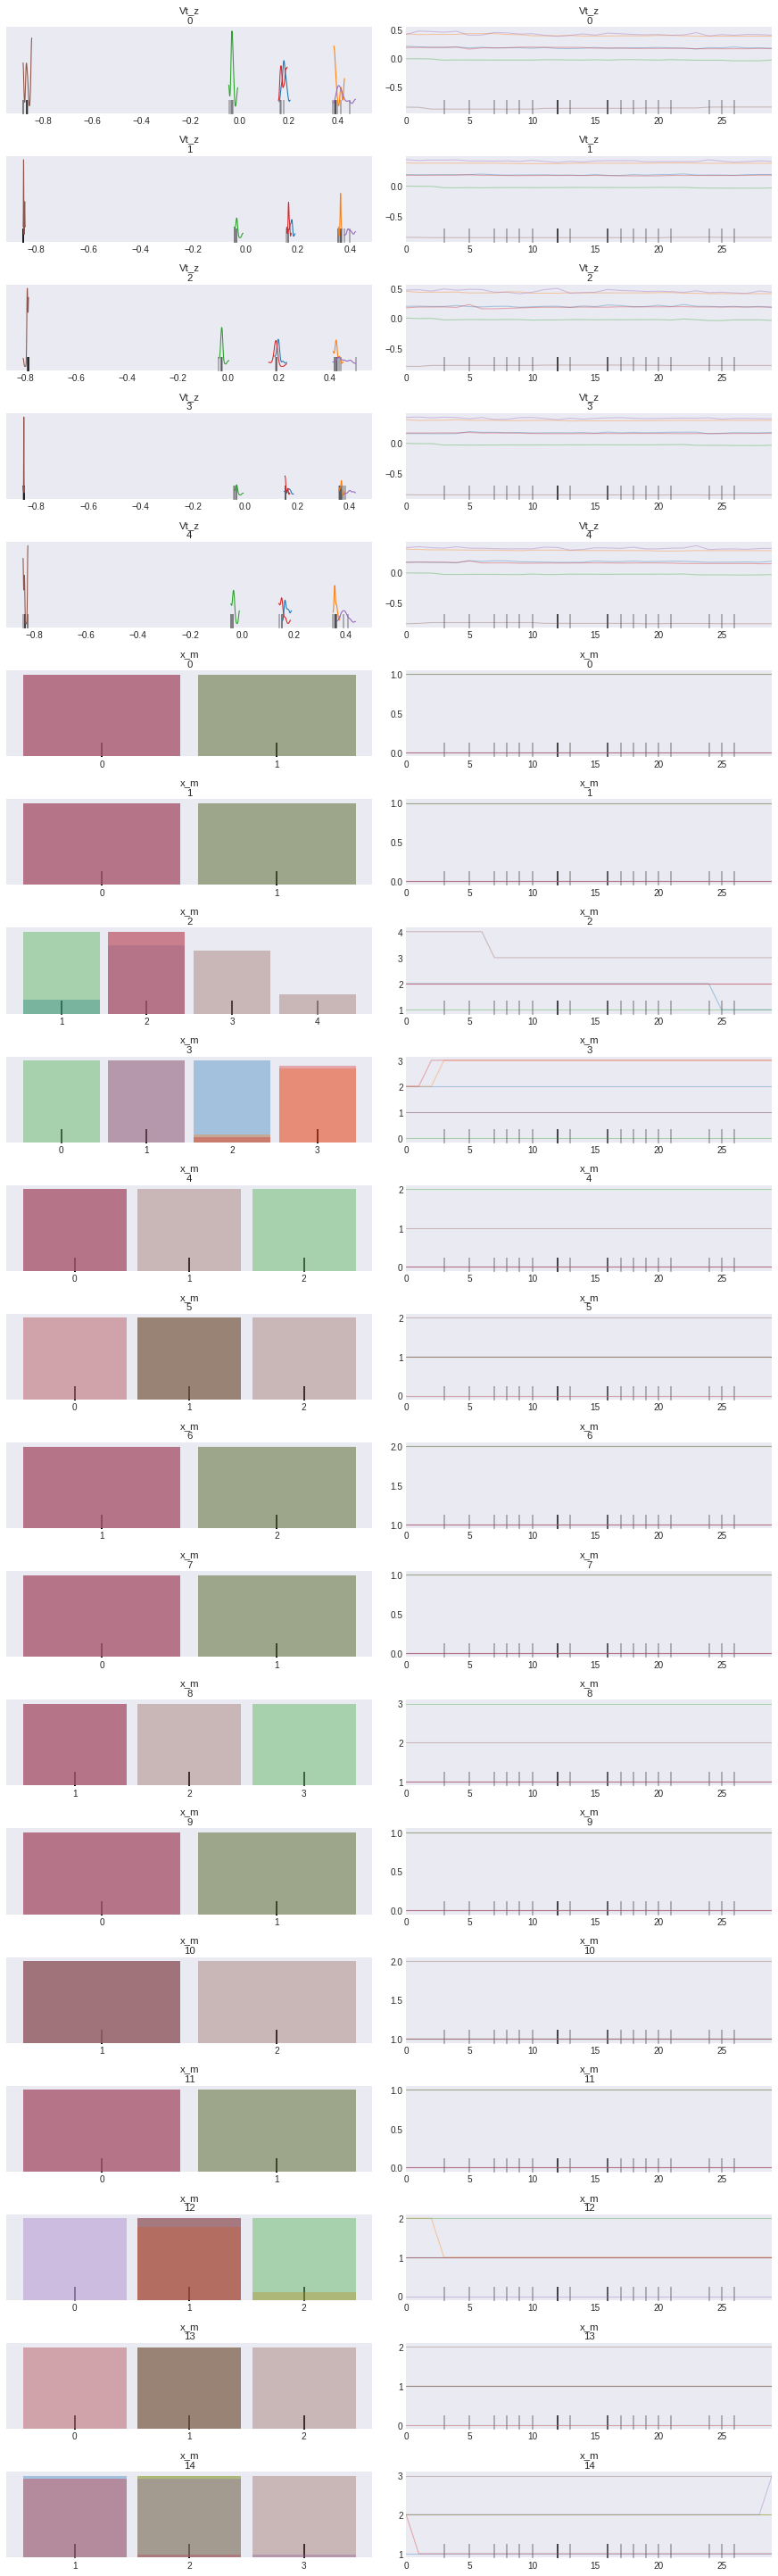

In [82]:
pm.plot_trace(hmN_burned)
plt.show()

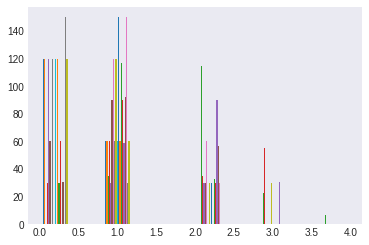

In [78]:
plt.hist(hmN_burned['x_m'])
plt.show()

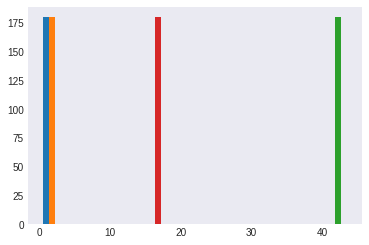

In [84]:
plt.hist(hmN_burned['eta_is'])
plt.show()

## 1.2 - C_ismt

In [173]:
?pm.distributions.continuous.Normal

In [191]:
#using dataframe categories
t=time()
with pm.Model() as hmC:
    ni_z=pm.Normal('ni_z',mu=0,sigma=50, shape=total_shape[2])
    alpha_is=pm.HalfNormal('alpha_is',sigma=20, shape=total_shape[1])
#     til_eta_is=pm.Deterministic('til_eta_is', np.exp(eta_is))
    zeta_m=pm.Poisson('zeta_m', n_medium, shape=total_shape[3])
    tau_m=pm.Poisson('tau_m', 3, shape=total_shape[4])
#     lamb=pm.Deterministic('lambda', 
#                           (tt.exp(ni_z[idx[:,2]] + alpha_is[idx[:,1]] + zeta_m[idx[:,3]] * tau_m[idx[:,4]]))/
#                           (1+tt.exp(ni_z[idx[:,2]] + alpha_is[idx[:,1]] + zeta_m[idx[:,3]] * tau_m[idx[:,4]]))
#                          )
    lamb=pm.Deterministic('lambda', 
                          tt.true_div(
                                      1,
                                      (1+tt.exp(ni_z[idx[:,2]] + alpha_is[idx[:,1]] + zeta_m[idx[:,3]] * tau_m[idx[:,4]]))
                                  )
                         )
#     lamb=(tt.exp(ni_z[idx[:,2]] + alpha_is[idx[:,1]] + zeta_m[idx[:,3]] * tau_m[idx[:,4]])/
#           (1+tt.exp(ni_z[idx[:,2]] + alpha_is[idx[:,1]] + zeta_m[idx[:,3]] * tau_m[idx[:,4]]))
#          )
    
    #likelihood
    cvs=pm.Binomial('cvs',p=lamb,n=df.shape[0],observed=(df['is_conversion'].values+1))

    #Sampling...
#     step=pm.Metropolis()
    hmC_trace = pm.sample(
                                   n_sampling
#                                    ,step=step
                                  #  ,chains=2
                                   ,cores=6
                                   )

    # prev_trace=hierarchical_trace[:n_burned]
    hmC_burned=hmC_trace[n_burned:]
    # t_n=pm.sample_posterior_predictive(burned_trace,samples=250)
    # test=pm.rhat(burned_trace)
print(time()-t) #0 cores = 249 s - 8 cores =  239 s - 4 cores = 245 - 16 cores = 237  - 32 = 246 - 64 = 236

INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:CompoundStep
INFO:pymc3:>NUTS: [alpha_is, ni_z]
INFO:pymc3:>CompoundStep
INFO:pymc3:>>Metropolis: [tau_m]
INFO:pymc3:>>Metropolis: [zeta_m]


ValueError: Not enough samples to build a trace.

In [ ]:
map_estimate = pm.find_MAP(model=hmC)
map_estimate

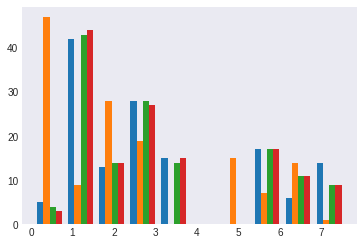

In [188]:
plt.hist(hm_C_burned['alpha_is'])
plt.show()

# 2- Test MCMC pystan

In [5]:
stan_model = """
    data {
        int<lower=0> num_samples;
        int<lower=0> num_s;
        int<lower=0> num_z;
        int<lower=1> s[num_samples];
        int<lower=1> z[num_samples];
        int<lower=1> sz[num_samples];
        vector[num_samples] Nviews;
    }
    parameters {
        vector<lower=0>[num_s] Ns;
        vector[num_z] Vtz;
    }
    model {
        Ns ~ normal(10.0, 10.0);
        Vtz ~ normal(0.0, 10.0);
        Nviews ~ normal(Ns[s] + Vtz[z],10);
    }
"""
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_996081802a3af8b59491b3e34b94a35b NOW.
